In [1]:
from bokeh.io import output_file, save, output_notebook, show
import pandas as pd
folderpath = './data_bi/'
filepath = folderpath + 'patents_with_title.csv'
data = pd.read_csv(filepath , sep = ";", usecols = ['patent_number','assignee_organization','cpc_group_id','inventor_last_name'],
                    dtype={'patent_number': str, 'cited_patent_number': str,'cpc_group_id':str,'inventor_last_name':str})
data.head()

C:\Users\tom-n\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,patent_number,inventor_last_name,assignee_organization,cpc_group_id
0,10013573,Dillenberger,International Business Machines Corporation,G06F
1,10013573,Dillenberger,International Business Machines Corporation,H04L
2,10013573,Dillenberger,International Business Machines Corporation,G06F
3,10013573,Dillenberger,International Business Machines Corporation,H04L
4,10022613,Tran,NaN,A41D


In [2]:
data.assignee_organization.fillna(data['inventor_last_name'],
inplace = True)
data.drop(["inventor_last_name"], axis = 1, inplace = True)

In [3]:
# Duplikate entfernen
data.drop_duplicates(['patent_number', 'assignee_organization', 'cpc_group_id'],keep = 'first', inplace = True)
data.columns = ["patent_id", "organization", "patent_group"]

In [4]:
# Duplikate entfernen
assignee_data = data.drop_duplicates(['patent_id', 'organization'],keep = 'first')
assignee_data

,patent_id,organization,patent_group
0,10013573,International Business Machines Corporation,G06F
4,10022613,Tran,A41D
2524,10026082,MASTERCARD INTERNATIONAL INCORPORATED,G06Q
2542,10044369,"Centri Technology, Inc.",H03M
2552,10046228,Tran,A41D
...,...,...,...
196568,9967096,Accenture Global Services Limited,G06F
196898,9979718,NEC Corporation Of America,G06F
197010,9990504,Northern Trust Corporation,G06F
197430,9992022,Northern Trust Corporation,G06F


In [5]:
#assignee_data.columns = ["patent_id", "organization", "patent_group"]

In [6]:
data_grouped_by_assignee = assignee_data.groupby('organization').count()
data_grouped_by_assignee.head()

,patent_id,patent_group
organization,,
"A9.com, Inc.",1,1
"ADP, LLC",3,3
ADVANCED MEDICAL SOLUTIONS LIMITED,1,1
"ADVANCED NEW TECHNOLOGIES CO., LTD.",42,34
"ALTR Solutions, Inc.",1,1


In [7]:
# Top 20 identifizieren
data_grouped_by_assignee_largest = data_grouped_by_assignee.nlargest(20, 'patent_id')
top_assignees = data_grouped_by_assignee_largest.index

In [8]:
data_top_assignees = data[data['organization'].isin(top_assignees)]
data_top_assignees.head()


,patent_id,organization,patent_group
0,10013573,International Business Machines Corporation,G06F
1,10013573,International Business Machines Corporation,H04L
2524,10026082,MASTERCARD INTERNATIONAL INCORPORATED,G06Q
8126,10063529,Accenture Global Services Limited,B29C
8127,10063529,Accenture Global Services Limited,B33Y


In [9]:
# Aggregieren der Daten nach Patentklassen, so dass die Top-Patentklassen ausgewählt werden können
assignee_cpc = data.drop_duplicates(['patent_id', 'patent_group'],keep = 'first')
data_grouped_by_class = assignee_cpc.groupby('patent_group').count()
data_grouped_by_class_largest = data_grouped_by_class.nlargest(20, 'patent_id')
top_groups = data_grouped_by_class_largest.index
data_top_groups = data_top_assignees[data_top_assignees["patent_group"].isin(top_groups)]

In [10]:
data_agg = data_top_groups.groupby(["organization", "patent_group"]).count()
data_agg.head()

patent_id
organization                        patent_group           
ADVANCED NEW TECHNOLOGIES CO., LTD. G06F                 27
                                    G06N                  1
                                    G06Q                 16
                                    H04L                 31
Accenture Global Services Limited   B33Y                  2

In [11]:
data_matrix = data_agg.unstack()

In [12]:
data_matrix.fillna(0, inplace = True)
data_matrix.iloc[0:5, 0:7].head()

patent_id                                 
patent_group                             A63F B33Y G05D   G06F G06K G06N  G06Q
organization                                                                  
ADVANCED NEW TECHNOLOGIES CO., LTD.       0.0  0.0  0.0   27.0  0.0  1.0  16.0
Accenture Global Services Limited         0.0  2.0  0.0   27.0  0.0  0.0  15.0
Alibaba Group Holding Limited             0.0  0.0  0.0  122.0  0.0  0.0  62.0
Bahga                                     0.0  0.0  0.0    5.0  0.0  0.0  11.0
Blockchain ASICs Inc.                     0.0  0.0  0.0    7.0  0.0  0.0   0.0

In [13]:
anzahl_cluster = 5

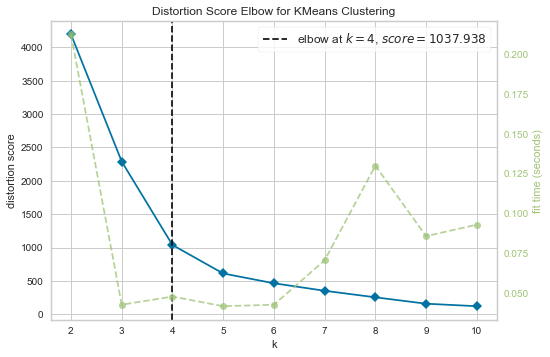

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(data_matrix)
visualizer.poof()

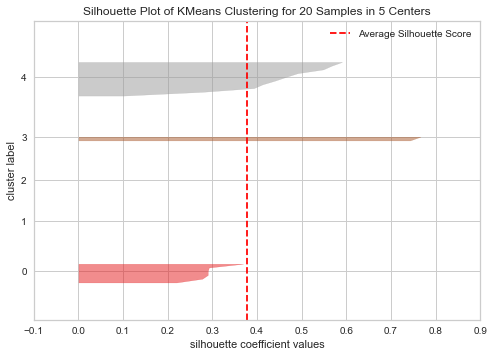

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 20 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(anzahl_cluster)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(data_matrix)
visualizer.poof()

In [16]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=anzahl_cluster).fit(data_matrix)

In [17]:
data_cluster = pd.DataFrame({"Cluster":cluster.labels_}, index = data_matrix.index)
data_cluster.sort_values("Cluster")

,Cluster
organization,
Alibaba Group Holding Limited,0
Bahga,1
NEC Corporation Of America,1
"Capital One Services, LLC",1
Madisetti,1
MASTERCARD INTERNATIONAL INCORPORATED,1
STATE FARM MUTUAL AUTOMOBILE INSURANCE COMPANY,1
International Business Machines Corporation,2
"ADVANCED NEW TECHNOLOGIES CO., LTD.",3


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
similarity = cosine_similarity(data_matrix)

In [20]:
sim_df = pd.DataFrame(similarity, index=data_matrix.index, columns = data_matrix.index)
sim_df.iloc[0:10, 0:2].head()

organization,"ADVANCED NEW TECHNOLOGIES CO., LTD.",Accenture Global Services Limited
organization,,
"ADVANCED NEW TECHNOLOGIES CO., LTD.",1.000000,0.990196
Accenture Global Services Limited,0.990196,1.000000
Alibaba Group Holding Limited,0.997281,0.992333
Bahga,0.897307,0.881556
Blockchain ASICs Inc.,0.929459,0.932568


In [21]:
sim_df = sim_df.stack()
type(sim_df)

pandas.core.series.Series

In [22]:
sim_df = pd.DataFrame(sim_df)
sim_df.head()

0
organization                        organization                                 
ADVANCED NEW TECHNOLOGIES CO., LTD. ADVANCED NEW TECHNOLOGIES CO., LTD.  1.000000
                                    Accenture Global Services Limited    0.990196
                                    Alibaba Group Holding Limited        0.997281
                                    Bahga                                0.897307
                                    Blockchain ASICs Inc.                0.929459

In [23]:
# Ähnlichkeiten im DataFrame zusammenführen
sim_df.index.rename(["Org_A", "Org_B"], inplace = True)
sim_df.head()

0
Org_A                               Org_B                                        
ADVANCED NEW TECHNOLOGIES CO., LTD. ADVANCED NEW TECHNOLOGIES CO., LTD.  1.000000
                                    Accenture Global Services Limited    0.990196
                                    Alibaba Group Holding Limited        0.997281
                                    Bahga                                0.897307
                                    Blockchain ASICs Inc.                0.929459

In [24]:
merged = sim_df.merge(data_cluster, left_on = "Org_A", right_index = True)
merged = merged.merge(data_cluster, left_on = "Org_B", right_index = True)
merged.head()

,,0,Cluster_x,Cluster_y
Org_A,Org_B,,,
"ADVANCED NEW TECHNOLOGIES CO., LTD.","ADVANCED NEW TECHNOLOGIES CO., LTD.",1.000000,3,3
Accenture Global Services Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.990196,3,3
Alibaba Group Holding Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.997281,0,3
Bahga,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.897307,1,3
Blockchain ASICs Inc.,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.929459,4,3


In [25]:
merged.reset_index(inplace = True)
merged.columns = ["Org_A", "Org_B", "Similarity", "Cluster_A", "Cluster_B"]
merged.head()


,Org_A,Org_B,Similarity,Cluster_A,Cluster_B
0,"ADVANCED NEW TECHNOLOGIES CO., LTD.","ADVANCED NEW TECHNOLOGIES CO., LTD.",1.000000,3,3
1,Accenture Global Services Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.990196,3,3
2,Alibaba Group Holding Limited,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.997281,0,3
3,Bahga,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.897307,1,3
4,Blockchain ASICs Inc.,"ADVANCED NEW TECHNOLOGIES CO., LTD.",0.929459,4,3


In [26]:
merged.sort_values("Similarity",ascending=False)

,Org_A,Org_B,Similarity,Cluster_A,Cluster_B
399,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",1.000000,4,4
42,Alibaba Group Holding Limited,Alibaba Group Holding Limited,1.000000,0,0
84,Blockchain ASICs Inc.,Blockchain ASICs Inc.,1.000000,4,4
90,"GSC Secrypt, LLC",Blockchain ASICs Inc.,1.000000,4,4
204,Blockchain ASICs Inc.,"GSC Secrypt, LLC",1.000000,4,4
...,...,...,...,...,...
188,"Cognitive Scale, Inc.",EMC IP Holding Company LLC,0.339827,4,4
388,"Cognitive Scale, Inc.","Wells Fargo Bank, N.A.",0.327785,4,4
179,"Wells Fargo Bank, N.A.","Cognitive Scale, Inc.",0.327785,4,4
228,"Cognitive Scale, Inc.",Guardtime SA,0.316942,4,4


In [27]:
merged.sort_values(["Cluster_A", "Cluster_B"], inplace = True)

In [28]:
# Bibliotheken importieren
#from bokeh.io import reset_output, output_notebook, show
from bokeh.models import ColumnDataSource, Title, HoverTool
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.models import LinearColorMapper
from bokeh.palettes import RdYlGn
import numpy as np

In [29]:
mapper = LinearColorMapper(palette=RdYlGn[7], low=merged["Similarity"].min(),
high=merged["Similarity"].max())

In [30]:
# Daten vorbereiten
source = ColumnDataSource(merged)

In [31]:
# HoverTool konfigurieren
hover = HoverTool(tooltips=[("Organisation 1", "@Org_A"),("Organisation 2", "@Org_B"),("Ähnlichkeit", "@Similarity")])

In [32]:
tools = [hover, "pan","wheel_zoom","box_zoom","reset", "save"]

In [33]:
p = figure(title="Heatmap Anmelder", x_axis_location="above", tools=tools, x_range=merged["Org_A"].unique(), y_range=list(reversed(merged["Org_B"].unique())))
p.plot_width = 800
p.plot_height = 800
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3

In [34]:
p.rect('Org_A', 'Org_B', 0.9, 0.9, source=source,
fill_color = transform("Similarity", mapper),
hover_line_color='black',
hover_color = transform("Similarity", mapper))
#get_screenshot_as_png(p)
show(p)